<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [112]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [113]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-03-29 04:27:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-03-29 04:27:58 (59.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [114]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [115]:
df.shape

(346, 10)

### Convert to date time object


In [116]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [117]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [158]:
# notice: installing seaborn might takes a few minutes
'''!conda install -c anaconda seaborn -y'''

'!conda install -c anaconda seaborn -y'

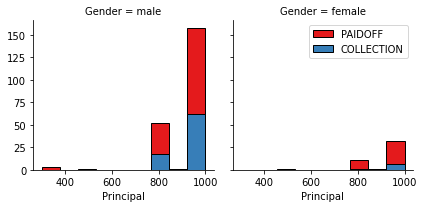

In [118]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

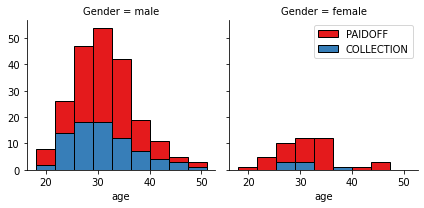

In [119]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


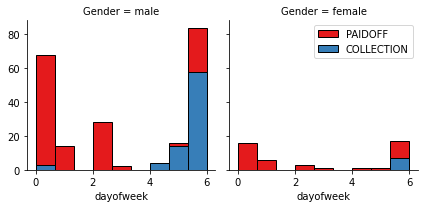

In [120]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [121]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [122]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [123]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [124]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [125]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [126]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [127]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [128]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [129]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random)
print('Train set:', X_train.shape, y_train.shape)
print('Train set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Train set: (70, 8) (70,)


In [131]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.67142857, 0.61428571, 0.67142857, 0.6       , 0.62857143,
       0.65714286, 0.67142857, 0.68571429, 0.75714286, 0.7       ,
       0.72857143, 0.74285714, 0.75714286, 0.75714286])

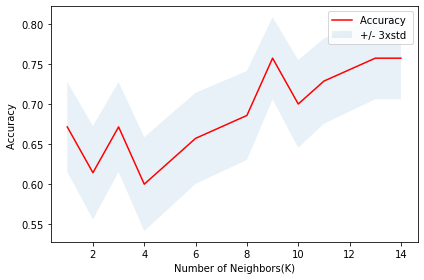

In [132]:
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors(K)')
plt.tight_layout()
plt.show()

In [133]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7571428571428571 with k= 9


In [134]:
k=mean_acc.argmax()+1
loanknn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
loanknn

KNeighborsClassifier(n_neighbors=9)

In [135]:
yhat = loanknn.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Decision Tree


In [136]:
from sklearn.tree import DecisionTreeClassifier

md = 15
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))

for n in range(3,md):
    loant = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=loant.predict(X_test)
    acc = metrics.accuracy_score(y_test, yhat)
    mean_acc[n-1]=acc
    print("Accuracy of decision tree: ", acc, ", at depth = ", n)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

Accuracy of decision tree:  0.6571428571428571 , at depth =  3
Accuracy of decision tree:  0.6285714285714286 , at depth =  4
Accuracy of decision tree:  0.7285714285714285 , at depth =  5
Accuracy of decision tree:  0.6428571428571429 , at depth =  6
Accuracy of decision tree:  0.6571428571428571 , at depth =  7
Accuracy of decision tree:  0.6428571428571429 , at depth =  8
Accuracy of decision tree:  0.6571428571428571 , at depth =  9
Accuracy of decision tree:  0.6285714285714286 , at depth =  10
Accuracy of decision tree:  0.6 , at depth =  11
Accuracy of decision tree:  0.6142857142857143 , at depth =  12
Accuracy of decision tree:  0.5857142857142857 , at depth =  13
Accuracy of decision tree:  0.5857142857142857 , at depth =  14


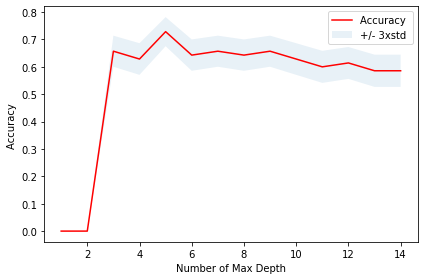

In [137]:
plt.plot(range(1,md),mean_acc,'r')
plt.fill_between(range(1,md),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Max Depth')
plt.tight_layout()
plt.show()

In [138]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7285714285714285 with k= 5


In [139]:
depth=mean_acc.argmax()+1
loandt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
loandt 

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [140]:
loandt.fit(X_train,y_train)
yhat= loandt.predict(X_test)

In [141]:
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Support Vector Machine


In [142]:
from sklearn import svm

loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_1 = metrics.accuracy_score(y_test, yhat1)

loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_2 = metrics.accuracy_score(y_test, yhat2)

loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_3 = metrics.accuracy_score(y_test, yhat3)

loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_4 = metrics.accuracy_score(y_test, yhat4)

print('Accuracy using SVM Radial basis function kernel',svm_1)
print('Accuracy using SVM Linear kernel',svm_2)
print('Accuracy using SVM Polynomial kernel',svm_3)
print('Accuracy using SVM Sigmoid kernel',svm_4)

Accuracy using SVM Radial basis function kernel 0.7285714285714285
Accuracy using SVM Linear kernel 0.7857142857142857
Accuracy using SVM Polynomial kernel 0.7428571428571429
Accuracy using SVM Sigmoid kernel 0.7285714285714285


In [143]:
loansvm = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat = loansvm.predict(X_test)
yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Logistic Regression


In [144]:
from sklearn.linear_model import LogisticRegression

loanlr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = loanlr1.predict(X_test)
loanlr_a1 = metrics.accuracy_score(y_test, yhat1)

loanlr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = loanlr2.predict(X_test)
loanlr_a2 = metrics.accuracy_score(y_test, yhat2)

loanlr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = loanlr3.predict(X_test)
loanlr_a3 = metrics.accuracy_score(y_test, yhat3)

loanlr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = loanlr4.predict(X_test)
loanlr_a4 = metrics.accuracy_score(y_test, yhat4)

loanlr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = loanlr5.predict(X_test)
loanlr_a5 = metrics.accuracy_score(y_test, yhat5)

print('Accuracy with Linear Regression liblinear solver model',loanlr_a1)
print('Accuracy with Linear Regression sag solver model',loanlr_a2)
print('Accuracy with Linear Regression saga solver model',loanlr_a3)
print('Accuracy with Linear Regression newton-cg solver model',loanlr_a4)
print('Accuracy with Linear Regression lbfgs solver model',loanlr_a5)

Accuracy with Linear Regression liblinear solver model 0.7142857142857143
Accuracy with Linear Regression sag solver model 0.7857142857142857
Accuracy with Linear Regression saga solver model 0.7857142857142857
Accuracy with Linear Regression newton-cg solver model 0.7857142857142857
Accuracy with Linear Regression lbfgs solver model 0.7857142857142857


In [145]:
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver set()
The label missing in the LR model with sag solver {'COLLECTION'}
The label missing in the LR model with saga solver {'COLLECTION'}
The label missing in the LR model with newton-cg solver {'COLLECTION'}
The label missing in the LR model with lbfgs solver {'COLLECTION'}


In [146]:
loanlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = loanlr.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Model Evaluation using Test set


In [147]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [148]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-03-29 04:28:40--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-03-29 04:28:41 (40.2 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [149]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [150]:
df = test_df
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [151]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [152]:
X_test = Feature
y_test = df['loan_status'].values
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [153]:
yhat_knn = loanknn.predict(X_test)
f1_knn=f1_score(y_test, yhat_knn, average='weighted')
print('f1 Score is', f1_knn)
jsc_knn=jaccard_score(y_test, yhat_knn, pos_label = "PAIDOFF")
print('Jacard similarity score is',jsc_knn)

f1 Score is 0.6871008939974457
Jacard similarity score is 0.7058823529411765


In [154]:
yhat_dt= loandt.predict(X_test)
f1_dt=f1_score(y_test, yhat_dt, average='weighted')
print('f1 Score is',f1_dt)
jsc_dt=jaccard_score(y_test, yhat_dt, pos_label = "PAIDOFF")
print('Jacard similarity score is',jsc_dt)

f1 Score is 0.7288207747977863
Jacard similarity score is 0.74


In [155]:
yhat_svm = loansvm.predict(X_test)
f1_svm=f1_score(y_test, yhat_svm, average='weighted')
print('f1 Score is',f1_svm)
jsc_svm=jaccard_score(y_test, yhat_svm, pos_label = "PAIDOFF")
print('Jacard similarity score is',jsc_svm)

f1 Score is 0.6304176516942475
Jacard similarity score is 0.7407407407407407


In [156]:
yhat_lr = loanlr.predict(X_test)
f1_lr=f1_score(y_test, yhat_lr, average='weighted')
print('f1 Score is',f1_lr)
jsc_lr=jaccard_score(y_test, yhat_lr, pos_label = "PAIDOFF")
print('Jacard similarity score is',jsc_lr)
yhat_lr_prob = loanlr.predict_proba(X_test)
ll_lr = log_loss(y_test, yhat_lr_prob)
print('Log loss is',ll_lr)

f1 Score is 0.7427039191745074
Jacard similarity score is 0.7843137254901961
Log loss is 0.570552587515225


In [157]:
F1_score = [f1_knn,f1_dt,f1_svm,f1_lr]
Jaccard = [jsc_knn,jsc_dt,jsc_svm,jsc_lr]
LogLoss = ['NA','NA','NA',ll_lr]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard,'F1-score': F1_score,  'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.705882,0.687101,NA
1,Decistion Tree,0.740000,0.728821,NA
2,SVM,0.740741,0.630418,NA
3,LogisticRegression,0.784314,0.742704,0.570553


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.705882| 0.687101 |  NA     |
| Decision Tree      | 0.740000| 0.728821 |  NA     |
| SVM                | 0.740741| 0.630418 |  NA     |
| LogisticRegression | 0.784314| 0.742704 | 0.570553|


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
